# Guess My Word

#### Authors:
v1.0 (Spring 2020) William Gan, Kannan Ramchandran

## Introduction

In Guess My Word http://hryanjones.com/guess-my-word/, you make guesses at a secret word and the computer tells you if it's before or after. Being bad at it, Efe wants to write a program to solve it. In this lab, you'll explore a couple ideas he has and help him write the program.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Modeling the Game

Suppose we have obtained a list of the words used in the game. Each word has a frequency representing relatively how often it appears in the English language. Suppose the secret word is chosen proportionally to this frequency. The code in the cells below simulate the game. A couple things to note:

- The frequency is not a probability i.e. it is unnormalized.
- In this version of the game, we're assuming guesses come from the list of possible words used.
- We're also assuming that you aren't told the secret word if you guess it. You have to deduce it yourself.

In [2]:
from words import WORD_FREQ

In [3]:
type(WORD_FREQ)

dict

In [4]:
total_freq = sum(WORD_FREQ.values())
sorted_words = sorted(list(WORD_FREQ))
sorted_word_freqs = np.array([WORD_FREQ[w] for w in sorted_words])
cum_freqs = np.cumsum(sorted_word_freqs)

In [5]:
print(f'Total frequency: {total_freq}')
print(f'First 10 words sorted: {sorted_words[:10]}')
print(f'Frequencies associated with these words: {sorted_word_freqs[:10]}')
print(f'Cumulative freqs associated with these words: {cum_freqs[:10]}')

Total frequency: 37009
First 10 words sorted: ['abstain', 'accept', 'across', 'action', 'active', 'adhere', 'afraid', 'against', 'alive', 'allegory']
Frequencies associated with these words: [  2  24 111 122  23   1 116 221  16   1]
Cumulative freqs associated with these words: [  2  26 137 259 282 283 399 620 636 637]


The following function will use binary search to find the word associated with an idx, which should be from 0 to total_freq-1. For example, `binary_search_word_generation(126)` will return the 3rd word, "across".

In [6]:
def binary_search_word_generation(idx):
    i, j = 0, len(sorted_words) - 1
    while i < j:
        mid = (i + j) // 2
        if cum_freqs[mid] > idx:
            j = mid
        else:
            i = mid + 1
    return i

**In the following cell, implement `generate_secret_word` using `binary_search_word_generation`.**

In [19]:
def generate_secret_word():
    return sorted_words[binary_search_word_generation(np.random.randint(0, total_freq))]

This cell creates a game by generating a secret word and returning `guess_function`. `guess_function` returns True if the guess is lexicographically "less than" the secret word.

In [8]:
def create_game(secret_word):
    def guess_function(guess):
        assert guess in WORD_FREQ
        return guess < secret_word
    return guess_function

## Binary Search Idea

The first idea is to ignore the frequencies and binary search on the correct word. In the cell below, `binary_search_game` receives a `guess_function` which was created by a call to `create_game`. Your code should use this `guess_function` to deduce what the secret word was, as well as keep track of how many guesses it took. **In the cell below, write code that returns the deduced secret word and number of guesses required**.  

*Hint: If you want help implementing binary search, you could model it off of `binary_search_word_generation`.*

In [9]:
def binary_search_game(guess_function):
    guesses = 0
    deduced_word = None
    # BEGIN YOUR SOLUTION
    i, j = 0, len(sorted_words) - 1
    while i < j:
        mid = (i + j) // 2
        guesses += 1
        if guess_function(sorted_words[mid]):
            j = mid
        else:
            i = mid + 1
    deduced_word = sorted_words[i]
    # END YOUR SOLUTION
    return deduced_word, guesses

Use the following function to test your code. **While your implementation may not get the exact same number of guesses, it should take 9 or 10 guesses**. **It should also be deducing the correct word**.

In [10]:
def test_binary_search_game():
    '''Sanity checks for binary_search_game.'''
    words = ['find', 'time', 'great', 'anyone', 'lying']
    print([binary_search_game(create_game(w)) for w in words])

In [11]:
# Staff solution gets [('find', 10), ('time', 10), ('great', 10), ('anyone', 10), ('lying', 9)].
test_binary_search_game()

[('zone', 9), ('abstain', 10), ('zone', 9), ('zone', 9), ('zone', 9)]


## Huffman Coding Idea

The second idea uses the frequencies and is similar to [Huffman Coding](https://en.wikipedia.org/wiki/Huffman_coding).

It works as follows:

1. Sort all the words in alphabetical order in a list.
2. Go through all consecutive pairs of words. For each pair, consider the sum of the two frequencies. Find the pair whose sum is minimal.
3. Combine those two words into a node, and make the frequency their sum. The node's left child will be the first word in the pair and the node's right child will be the second word in the pair.
4. Replace the two words with the node in the list.
5. Go back to step 1, and now treating nodes and words as the same, repeat until there's only one node left.
6. This node is the root of the Huffman Tree.

When creating new nodes, we also need to set `rightmost_word`. It'll be useful when we try to guess the secret word, which works as follows.

1. Set the current node to the root.
2. Guess the `rightmost_word` of the current node's left child.
3. If this is before the secret word, than the secret word must be in the right child. Otherwise, it's in the left child.
4. Go back to step 2. Repeat until we've reached a leaf in this tree.

In [12]:
class HuffmanNode:
    def __init__(self, freq, word=None):
        # The total frequency of the words in our own subtree.
        self.freq = freq
        # Only non-null in leaf nodes.
        self.word = word
        # The rightmost word in our own subtree.
        self.rightmost_word = word
        # Our children nodes
        self.left_subtree = None
        self.right_subtree = None

**In the following cell, fill code to generate the HuffmanTree.**

In [13]:
def build_huffman_tree():
    sorted_words = sorted(list(WORD_FREQ))
    nodes = [HuffmanNode(WORD_FREQ[w], w) for w in sorted_words]
    # Will need to combine two nodes len(WORD_FREQ) - 1 times.
    for i in range(len(WORD_FREQ) - 1):
        min_node_idx = None
        min_freq = None
        # Choose the consecutive pair of nodes with smallest frequency sum to
        # combine.
        for j in range(0, len(nodes) - 1):
            freq = nodes[j].freq + nodes[j+1].freq
            if min_freq is None or freq < min_freq:
                min_node_idx = j
                min_freq = freq
        new_node = HuffmanNode(min_freq)
        # Setup the new node and then replace the current two nodes in the list
        # with the new node.
        # BEGIN YOUR SOLUTION
        new_node.left_subtree = nodes[min_node_idx]
        new_node.right_subtree = nodes[min_node_idx+1]
        new_node.rightmost_word = nodes[min_node_idx+1].rightmost_word
        nodes.pop(min_node_idx)
        nodes.pop(min_node_idx)
        nodes.insert(min_node_idx, new_node)
        # END YOUR SOLUTION
    return nodes[0]

**In the cell below, write code that plays a game with the HuffmanTree and returns the deduced word and number of guesses.**


In [14]:
root = build_huffman_tree()

def huffman_game(guess_function):
    guesses = 0
    deduced_word = None
    # BEGIN YOUR SOLUTION
    cur_node = root
    while cur_node.word is None:
        guesses += 1
        if guess_function(cur_node.left_subtree.rightmost_word):
            cur_node = cur_node.right_subtree
        else:
            cur_node = cur_node.left_subtree
    deduced_word = cur_node.word
    # END YOUR SOLUTION
    return deduced_word, guesses

Use the following function to test your code. **While your implementation may not get the exact same number of guesses, it should be deducing the correct word**.

In [15]:
def test_huffman_game():
    '''Sanity checks for huffman_game.
    
    The number of guesses may not be less than binary search for particular
    examples.
    '''
    words = ['find', 'time', 'great', 'anyone', 'lying']
    print([huffman_game(create_game(w)) for w in words])

In [16]:
# Staff solution gets [('find', 8), ('time', 6), ('great', 8), ('anyone', 8), ('lying', 10)].
test_huffman_game()

[('find', 8), ('time', 6), ('great', 8), ('anyone', 8), ('lying', 10)]


## Analysis

In this section, we'll try to compare the average number of guesses required by each of the two methods and connect it to entropy.

**In the following cell, compute the entropy of the distribution for the secret word.**

*Note: By default, np.log uses the natural log.*

In [21]:
entropy = None
## BEGIN YOUR SOLUTION
entropy = np.sum([-WORD_FREQ[w]/total_freq * np.log2(WORD_FREQ[w]/total_freq) for w in WORD_FREQ])
print(entropy)
## END YOUR SOLUTION

7.935746303074419


We'll use sampling to estimate the mean number of guesses for each method. In particular, if $X_i$ is the number of guesses required for trial $i$, we can approximate
$$
E[X] \approx \frac{1}{n} \sum_{i=1}^n X_i
$$

In [20]:
SAMPLES = 100000
binary_search = np.zeros(SAMPLES)
huffman = np.zeros(SAMPLES)
for i in range(SAMPLES):
    secret_word = generate_secret_word()
    _, binary_search[i] = binary_search_game(create_game(secret_word))
    _, huffman[i] = huffman_game(create_game(secret_word))

Text(0.5, 1.0, 'Guess My Word')

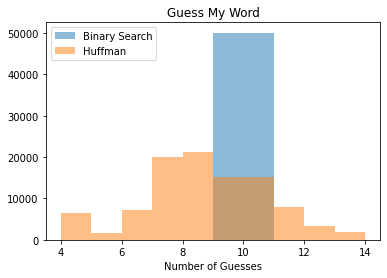

In [22]:
bins = np.arange(4, 15)
plt.hist(binary_search, bins, alpha=0.5, label='Binary Search')
plt.hist(huffman, bins, alpha=0.5, label='Huffman')
plt.xlabel('Number of Guesses')
plt.legend()
plt.title('Guess My Word')

In [23]:
print(np.mean(binary_search))
print(np.mean(huffman))

9.49955
8.26612


Let's create confidence intervals for $E[X]$. We know that $\frac{1}{n} \sum_{i=1}^n X_i \sim \mathcal{N}(E[X], \frac{var(X)}{n})$ by the CLT. **In the following cell, calculate `sigma_n` and `mu`**. We can use the sample mean to estimate $E[X]$ and sample variance to estimate $var(X)$.

In [24]:
def confidence_interval_95(samples):
    mu, sigma_n = 0, 0
    # BEGIN YOUR SOLUTION
    mu = np.mean(samples)
    sigma_n = np.std(samples)/np.sqrt(len(samples))
    
    # END YOUR SOLUTION
    return f'{mu:.3f} +- {1.96 * sigma_n:.3f}'

In [25]:
print(f'Binary Search: {confidence_interval_95(binary_search)}')
print(f'Huffman: {confidence_interval_95(huffman)}')

Binary Search: 9.500 +- 0.003
Huffman: 8.266 +- 0.013
